# Module Imports

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mne
import neurokit2 as nk
import nibabel as nb
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from cca_zoo.models import MCCA
from dcor import distance_correlation, rowwise
from matplotlib import cm, gridspec, colors
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mne.time_frequency import tfr_array_morlet, tfr_multitaper, tfr_morlet
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.glm_utils import linear_regression, onsets_to_block, xcorr
from utils.load_write import (
    load_subject_list, load_chang_bh_event_file,
    load_chang_cue_event_file, load_nki_event_file
)
from utils.notebook_utils import lag_basis, load_pca_results, load_subj
from patsy import dmatrix
from run_task_avg import construct_task_blocks
from scipy.io import loadmat
from scipy.signal import hilbert, welch, csd, find_peaks, resample
from scipy.interpolate import interp1d
from scipy.stats import zscore, circmean, circstd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# 1. Data Load

This section defines global variables for handing and visualing datasets, as well as loading the  PCA time courses from the 'run_pca.py' script (see below). Our analyses focus on the first principal component (PC1) that approximates the 'global signal', but one can adapt this code for analysis of any sort of signals derived from the functional MRI scans.

## 1.1 Choose Datasets and Define Global Variables

In [122]:
# choose datasets
datasets = ['chang', 'chang_bh', 'chang_cue', 'hcp', 
            'natview', 'nki', 'nki_rest', 'spreng', 'yale']

# Label dictionary (as labeled in the manuscript)
dataset_label_dict = {
    'chang': 'ME-REST',
    'chang_bh': 'ME-TASK',
    'hcp': 'HCP-REST',
    'natview': 'NATVIEW-REST',
    'nki': 'NKI-TASK',
    'nki_rest': 'NKI-REST',
    'spreng': 'ME-REST-SUPP',
    'yale': 'YALE-REST'
}

# Physio variable to label dictionary
physio_label_dict = {
    'PPG_HR': 'Heart Rate',
    'ECG_HR': 'Heart Rate',
    'PPG_LOW': 'PPG Low-Freq',
    'PPG_PEAK_AMP': 'PPG Amplitude',
    'RSP_RVT': 'Resp Volume',
    'GSR': 'Skin Conductance',
    'PUPIL': 'Pupil Diameter',
    'PC1': 'PC1',
    'ALPHA': 'Alpha EEG'
}

# Physio label colormaps
physio_cmap = plt.get_cmap('tab10')
color_dict = {
    'PC1': physio_cmap(0),
    'PPG_HR': physio_cmap(2),
    'PPG_PEAK_AMP': physio_cmap(3),
    'PPG_LOW': physio_cmap(4),
    'ALPHA': physio_cmap(5),
    'GSR': physio_cmap(6),
    'RSP_RVT': physio_cmap(7)
}


## 1.2. Load PCA Time Courses

PCA results for each dataset are produced by the 'run_pca.py' script in the base directory. By default the runner script ('run_all.py') saves the results as pickle (.pkl) files to the following file path 'results/pca'. If you put the PCA results in another directory, please change the file path below via the *pca_dir* variable. 

PCA is applied to the group-wise temporally concatenated BOLD time courses. Thus, the PC time courses must be 'de-concatenated' and assigned to each subject based on the order of the subjects concatenated in the 'run_pca.py' script. This is accomplished by both the order of the subjects in the concatenation and the length of the functional scan for each subject (in most cases, the length is identical across subjects). This order is determined based on the order of the subjects in the subject list .csv in each dataset directory (e.g. 'data/dataset_chang/subject_list_chang.csv'). If a dataset's subject list .csv file are manipulated (e.g. subject removed, re-ordered) **after** you run PCA via the 'run_pca.py', you should assume that the order is compromised, and that the PCA time courses produced from the code below are corrupted. Basically, if you change the subject file .csv for a dataset, re-run the 'run_pca.py' script before running the code below.

In [3]:
# load in dataset parameters
params = json.load(open('analysis_params.json', 'rb'))

# specify directory to pca results
pca_dir = 'results/pca'

# load pca time courses
pca_dict = {}
for d in datasets:
    pca_fp = f'{pca_dir}/{d}_pca_results.pkl'
    pca_dict[d], _ = load_pca_results(d, pca_fp, params[d])

## 1.3 Set Sign of First Principal Component

PCA dimensions suffer from a well-known sign-ambiguity, such that flipping the sign of the principal components represents an equally valid solution. This is problematic when comparing PCA solutions across datasets. For this study, we ensure that the distributed spatial weights of the first PC are positive across the gray matter. In datasets where the spatial weights are negative across the cortex, we sign-flip them to ensure all datasets are consistent. In principle, the code below should not need to be changed if the exact preprocessing and subjects are used as our study. But it is worth checking the PCA nifti output ('.nii' files) to ensure.

In [4]:
pca_sign_dict = {
    'chang': -1, 
    'chang_bh': 1, 
    'chang_cue': 1, 
    'hcp': 1, 
    'hrv': -1, 
    'natview': -1, 
    'nki': -1, 
    'nki_rest': 1,
    'spreng': -1, 
    'yale': -1
}

# 2. Cross-Correlations

## 2.1 Physio Cross-Correlations

Text(0.5, 1.0, 'PC1 - PPG Amplitude')

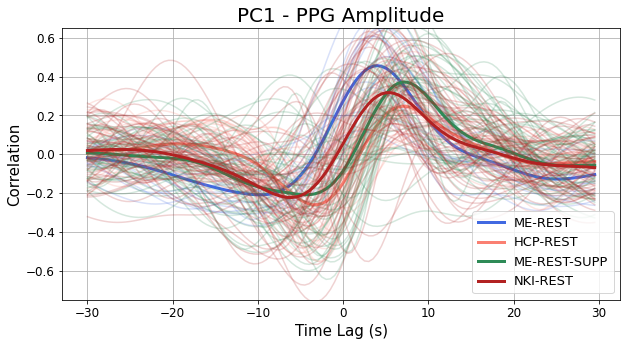

In [27]:
## Choose:
# Electrophysio Signals: PPG_LOW, RSP_RVT, PPG_HR, PPG_PEAK_AMP, ALPHA, PUPIL, GSR
e_signal = 'PPG_PEAK_AMP'

# dataset = ['chang', 'hcp', 'natview', 'nki_rest', 'spreng', 'yale']
datasets_cc = ['chang', 'hcp', 'spreng', 'nki_rest']

# pca index (0 - corresponds to first principal component)
pca_index = 0

# select time series similarity function ('correlation' or 'distance_correlation')
corr_func = 'correlation'

# set permutation parameters
permute=False
n_perm=500

# Max number of samples to display in cross-correlation plot
n_max = 50

fig, ax = plt.subplots(1,1, figsize=(10,5))

# Inperpolation parameters
x_interp = np.arange(-30, 30, 0.5)
# specify length of cross-correlation function based on TR.
# we try to get around 30s 
cc_len_dict = {d: np.ceil(30/params[d]['tr']).astype(int)
               for d in datasets_cc}

# Color dictionary
color_dict = {
    'chang': 'royalblue',
    'hcp': 'salmon',
    'spreng': 'seagreen',
    'natview': 'darkcyan',
    'yale': 'darkorange',
    'nki_rest': 'firebrick'
}

# specify pca label from PC index
pca_label = f"PC{pca_index+1}"

# Create permutations
if permute:
    permute_cc = {d: [] for d in datasets_cc}
    
# create time series similarity function
if corr_func == 'correlation':
    def ts_sim(x,y,maxlag):
        return xcorr(x, y, maxlags=maxlag)
elif corr_func == 'distance_correlation':
    def ts_sim(x,y, maxlag):
        lag_array = np.arange(-maxlag,maxlag+1)[::-1]
        x_shift = [np.roll(x, i) for i in lag_array]
        y_copy = [y for i in lag_array]
        cc = rowwise(distance_correlation, x_shift, y_copy)
        return lag_array[::-1], cc
    
# Loop through datasets and calculate cross-correlations
for d in datasets_cc:
    interp_cc = []
    # get subject list
    subject, scan = load_subject_list(d, params[d]['subject_list'])
    # loop through subjects and cross-correlate physio with PC time course
    for subj, sc in zip(subject, scan):
        # Load subject data
        df = load_subj(subj, sc, d, params[d], pca_dict[d][f'{subj}_{sc}'], 
                       pca_index=pca_index)
        # flip sign for PC1, if necessary
        if pca_index == 0:
            df['PC1'] = df['PC1'] * pca_sign_dict[d]
        # Compute cross-correlation
        cc_list = ts_sim(df[pca_label].values, df[e_signal].values, cc_len_dict[d])
        f_interp = interp1d(cc_list[0]*(params[d]['tr']), cc_list[1], kind='cubic')
        interp_cc.append(f_interp(x_interp))
        # Create permutation distribution, if specified
        if permute:
            permute_subj_cc = []
            for p in range(n_perm):
                # Supress divide by invalid value warning
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
                    surrogate = nk.signal_surrogate(df[e_signal].values, method='IAAFT', 
                                                    max_iter=100, atol=1e-5, rtol=1e-6)
                _, cc = ts_sim(df[pca_label].values, surrogate, cc_len_dict[d])
                permute_subj_cc.append(cc)
            permute_cc[d].append(np.vstack(permute_subj_cc))
    ax.plot(x_interp, np.mean(interp_cc, axis=0), linewidth=3, color=color_dict[d], 
            label=dataset_label_dict[d])
    interp_cc_sample = interp_cc[:n_max]
    ax.plot(x_interp, np.array(interp_cc_sample).T, color=color_dict[d], alpha=0.2)

ax.grid(True)
ax.legend(fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Time Lag (s)', fontsize=15)
if corr_func == 'correlation':
    ax.set_ylim([-0.75, 0.65])
    ax.set_ylabel('Correlation', fontsize=15)
elif corr_func == 'distance_correlation':
    ax.set_ylim([0, 0.65])
    ax.set_ylabel('Distance Correlation', fontsize=15)

if permute:
    for d in datasets_cc:
        perm_concat = np.stack(permute_cc[d], axis=2)
        perm_avg = np.abs(np.mean(perm_concat, axis=2))
        p_05 = np.quantile(perm_avg, 0.95)
        if corr_func == 'correlation':
            ax.axhline(p_05, 0, 1, color=color_dict[d], alpha=0.5, linestyle = '--')
            ax.axhline(-p_05, 0, 1, color=color_dict[d], alpha=0.5, linestyle = '--')
        elif corr_func == 'distance_correlation':
            ax.axhline(p_05, 0, 1, color=color_dict[d], alpha=0.7, linestyle = '--')
ax.set_title(f"{pca_label} - {physio_label_dict[e_signal]}", fontsize=20)

## 2.2 EEG Power Cross-Correlations

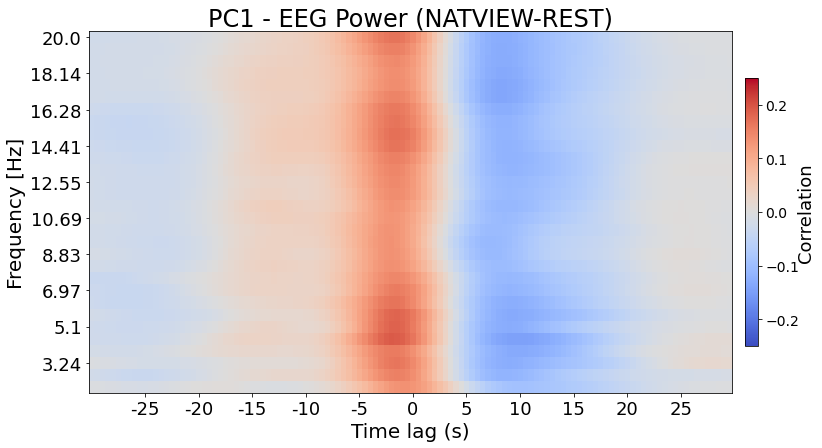

In [40]:
# choose dataset - natview, chang
dataset_power = 'natview'

# pca index (0 - corresponds to first principal component)
pca_index = 0

# Select frequencies (2 to 20 Hz)
freqs = np.linspace(2, 20, 30)[::-1]

# interpolation time points for smooth cross-corr estimation
x_interp = np.arange(-30, 30, 0.5)

# specify pca label from PC index
pca_label = f"PC{pca_index+1}"

# Loop through subjects and compute cross-correlations
subject, scan = load_subject_list(dataset_power, params[dataset_power]['subject_list'])
xcorr_results = []
for subj, sc in zip(subject, scan):
    # load subject dataframe with PC time course
    df = load_subj(subj, sc, dataset_power, params[dataset_power], 
                   pca_dict[dataset_power][f'{subj}_{sc}'], pca_index=pca_index)
    # flip sign for PC1, if necessary
    if pca_index == 0:
        df['PC1'] = df['PC1'] * pca_sign_dict[dataset_power]
    raw = mne.io.read_raw_fif(params[dataset_power]['eeg'].format(subj, sc), 
                              preload=True, verbose=False)
    func_len = nb.load(params[dataset_power]['func'].format(subj, sc)).shape[-1]
    # set n_cycle parameter for wavelet (> cycles, > frequency resolution & < time resolution)
    n_cycles = 15
    # Commented out multitaper power estimation approach
    # time_bandwidth = 4.0  
    # power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
    #                        time_bandwidth=time_bandwidth, return_itc=False, 
    #                        average=True)
    # Grab parameters
    times = raw.times; sfreq = raw.info['sfreq']
    # Get data into numpy array
    raw_data = raw.get_data()[np.newaxis,:]
    # Morlet time-frequency power estimation
    power = tfr_array_morlet(raw_data, sfreq, freqs, n_cycles=n_cycles, output='power')
    power_avg = np.squeeze(power).mean(axis=0)
    # loop through frequencies and calculate cross-correlation with PC time course
    xcorr_subj = []
    for i in range(len(freqs)):
        resample_freq = nk.signal_resample(power_avg[i,:], desired_length=func_len, 
                                           method='FFT')
        cc_list = xcorr(df[pca_label], resample_freq, maxlags=20)
        f_interp = interp1d(cc_list[0]*(params[dataset_power]['tr']), 
                            cc_list[1], kind='cubic')
        xcorr_subj.append(f_interp(x_interp))
    xcorr_results.append(np.vstack(xcorr_subj))  

# Plot
fig, ax = plt.subplots(figsize=(12,10))
xcorr_avg = np.stack(xcorr_results, axis=2).mean(axis=2)
im = ax.imshow(xcorr_avg, cmap='coolwarm', vmin=-0.25, vmax=0.25, aspect=2.25)
freq_sample = np.arange(0,len(freqs),3)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[freq_sample],2), fontsize=18)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
x_sample = np.arange(0,len(x_interp), 10)
ax.set_xticks(x_sample)
ax.set_xticklabels(x_interp[x_sample].astype(int), fontsize=18)
ax.set_xlabel('Time lag (s)', fontsize=20)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)
cbar = plt.colorbar(im,fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation', fontsize=18, labelpad=-2)
ax.set_title(f"{pca_label} - EEG Power ({dataset_label_dict[dataset_power]})", 
             fontsize=24)
plt.show()

# 3. Joint Co-Fluctuations - MCCA

## 3.1 Dataset Physio Selections

In [8]:
# choose vars for MCCA for each dataset
mcca_vars = {
    'chang': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'ALPHA'],
    'hcp': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP'],
    'natview': ['PC1', 'PUPIL', 'ALPHA'],
    'nki_rest': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'GSR'],
    'spreng': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP']
}

# set lags for each dataset - ~15s for each dataset
lag_n = {
    'chang': 7,
    'hcp': 20,
    'nki_rest': 11,
    'natview': 7,
    'spreng': 5
}

## 3.2 Multi-Set CCA

perm pval: 0.009900990099009901


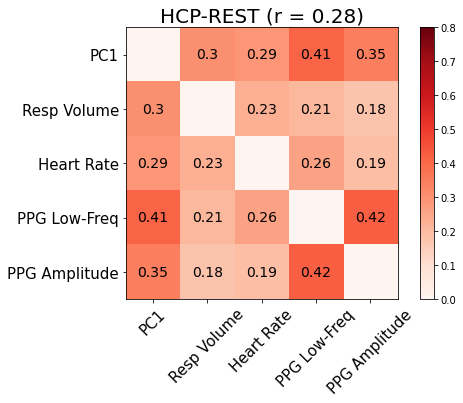

In [117]:
# chang, hcp, spreng, natview, nki_rest
dataset_mcca = 'hcp'

# pca index (0 - corresponds to first principal component)
pca_index = 0

# permutation parameters
permute=True
n_permute=100
permute_group = []

# spline basis parameters
nknots=3
lag_vec = np.arange(lag_n[dataset_mcca]+1)



basis_group = [[] for i in range(len(mcca_vars[dataset_mcca]))]
data_group = [[] for i in range(len(mcca_vars[dataset_mcca]))]
subject, scan = load_subject_list(dataset_mcca, params[dataset_mcca]['subject_list'])
for subj, sc in zip(subject, scan):
    # Load Subject
    df = load_subj(
        subj, sc, dataset_mcca, params[dataset_mcca],
        pca_dict[dataset_mcca][f'{subj}_{sc}'], pca_index=pca_index
    )
    # flip sign for PC1, if necessary
    if pca_index == 0:
        df['PC1'] = df['PC1'] * pca_sign_dict[d]
    # normalize data before concatenation
    df = df.apply(zscore, axis=0)
    # Create a separate dataframe for modeling w/ lag splines
    for i, p in enumerate(mcca_vars[dataset_mcca]):
        basis, lag_spline = lag_basis(df[p], lag_vec, nknots)
        # Trim NaNs introduced from lag splines
        na_indx = ~(np.isnan(basis).any(axis=1))
        basis_group[i].append(basis[na_indx, :])
        data_group[i].append(df[p].loc[na_indx])

basis_concat = [np.vstack(g) for g in basis_group]
data_concat = [np.hstack(g).T for g in data_group]


# Fit MCCA
mcca = MCCA(latent_dims=5, random_state=0)
mcca.fit(basis_concat)

# average pair-wise correlation
mcca_r = mcca.score(basis_concat)

# compute permutation distribution, if specified
if permute:
    perm_r = []
    n_subj = len(basis_group[0])
    for n in range(n_permute):
        subj_shuffle = []
        for b in range(len(basis_group)):
            subj_list = np.arange(n_subj)
            np.random.shuffle(subj_list)
            subj_shuffle.append(subj_list)
        perm_basis = [[basis[s] for s in subj_vec] for basis, subj_vec in zip(basis_group, subj_shuffle)]
        perm_basis_concat = [np.vstack(g) for g in perm_basis]
        # Fit MCCA
        mcca_cv = MCCA(latent_dims=3, random_state=0)
        mcca_cv.fit(perm_basis_concat)
        # MCCA corr
        perm_r.append(mcca_cv.score(perm_basis_concat)[0])

    print(f'perm pval: {(sum(perm_r > mcca_r[0]) + 1) / (len(perm_r) + 1)}')
# Plot correlation matrix
corr_mat = mcca.correlations(basis_concat)

new_labels = [physio_label_dict[p] for p in mcca_vars[dataset_mcca]]
corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=new_labels, index=new_labels)
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(corr_mat_array, vmin=0, vmax=0.8, cmap='Reds')
ax.set_xticks(np.arange(len(new_labels)))
ax.set_yticks(np.arange(len(new_labels)))
ax.set_xticklabels(new_labels, rotation=45, fontsize=15)
ax.set_yticklabels(new_labels, fontsize=15)

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center', fontsize=14)
ax.set_title(f"{dataset_label_dict[dataset_mcca]} (r = {round(mcca_r[0],2)})", 
             fontsize=20)
plt.colorbar(im, ax=ax)



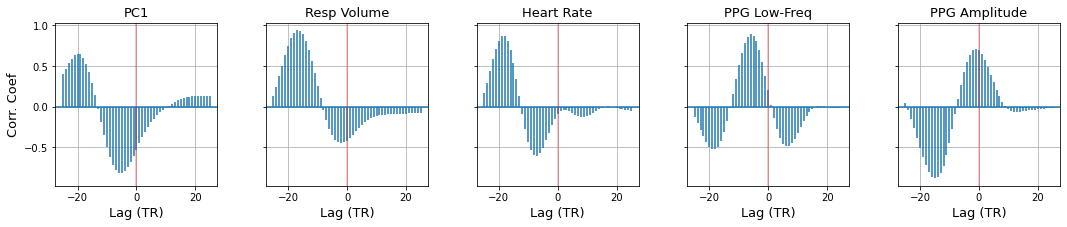

In [118]:
# Plot lags on first canonical component
cca_pred = mcca.transform(basis_concat)


cca_pred_df = pd.DataFrame(
    np.vstack([cca_pred[i][:,0] for i in range(len(new_labels))]).T,
    columns = new_labels
)

fig, axs = plt.subplots(nrows=1, ncols=len(new_labels), figsize=(18,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.3)

for i, ax in enumerate(axs):
    ax.xcorr(data_concat[i], cca_pred[i][:,0], maxlags=lag_n[dataset_mcca]+5)
    ax.set_xlabel('Lag (TR)', fontsize=13)
    ax.set_title(new_labels[i], fontsize=13)
    ax.axvline(0, 0, 1, alpha=0.3, color='red')
    if i == 0:
        ax.set_ylabel('Corr. Coef', fontsize=13)
    ax.grid(True)
    

# 4. Respiration Task Analysis

## 4.1 Auditory Cue - Deep Breath

### 4.1.1. Metadata

In [120]:
# Create task block indices
bh_events = load_chang_bh_event_file()
bh_event_blocks = construct_task_blocks('chang_bh', bh_events, 0)
bh_event_blocks = [tuple(b) for b in bh_event_blocks[0][1]]

cue_events = load_chang_cue_event_file()
cue_event_blocks = construct_task_blocks('chang_cue', cue_events, 0)
cue_event_blocks = [tuple(b) for b in cue_event_blocks[0][1]]

# Load compliance data for chang_bh data (i.e. did they take a breath)
compliance = pd.read_csv('data/dataset_chang_bh/compliance.csv')
compliance = compliance.set_index(
    compliance['subject'].astype(str) + '_' + compliance['scan'].astype(str)
)
trial_cols = [f'trial{n+1}' for n in range(9)]

# Specify subject scans
subj_scan_dict = {
    'chang_bh': {
        '15': ['0009', '0015'],
        '17': ['0006', '0015'],
        '19': ['0016', '0022'],
        '20': ['0012'],
        '21': ['0009'],
        '25': ['0012']
    },
    'chang_cue': {
        '16': ['0012'],
        '17': ['0012', '0018'],
        '19': ['0013', '0019'],
        '20': ['0009'],
        '21': ['0006']
    }
}

### 4.1.2 Across-Subject Trial Average

(-1.6, 2.5)

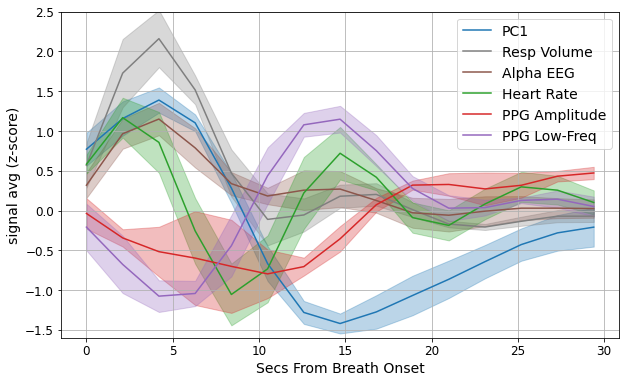

In [131]:
# chang_bh, chang_cue
dataset_avg = 'chang_bh'

# principal component index
pca_index = 0

# physiological signal selection
physio_select = ['PC1', 'RSP_RVT', 'ALPHA', 'PPG_HR', 'PPG_PEAK_AMP', 'PPG_LOW']

physio_labels = [physio_label_dict[p] for p in physio_select]
physio_list = [[] for i in range(len(physio_select))]

if dataset_avg == 'chang_bh':
    task_blocks = bh_event_blocks
elif dataset_avg == 'chang_cue':
    task_blocks = cue_event_blocks

# loop through subjects and their scans and event average
for subj in subj_scan_dict[dataset_avg]:
    physio_block_list = [[] for i in range(len(physio_select))]
    # Concatenate trials across scans from the same subject
    for scan in subj_scan_dict[dataset_avg][subj]:
        df_subj = load_subj(subj, scan, dataset_avg, params[dataset_avg], 
                            pca_dict[dataset_avg][f'{subj}_{scan}'], 
                            pca_index=pca_index)
        # flip sign for PC1, if necessary
        if pca_index == 0:
            df['PC1'] = df['PC1'] * pca_sign_dict['chang_bh']
        # normalize z-score for averaging
        df_subj = df_subj.apply(zscore, axis=0)
        if dataset_avg == 'chang_bh':
            # Load compliance for scan
            scan_compliance = compliance.loc[f'{subj}_{int(scan)}'][trial_cols].values
            # Filter out non-compliant trials
            task_blocks = [block for block, c in zip(task_blocks, scan_compliance) if c == 1]
        
        for i, p in enumerate(physio_select):
            p_ts = df_subj[p].values[np.newaxis, :]
            physio_block_list[i].append(np.squeeze(p_ts[:, task_blocks]))
    # Concatenate trials across scans
    physio_block_list = [np.vstack(p_blocks) for p_blocks in physio_block_list]
    for i, p in enumerate(physio_select):
        physio_list[i].append(physio_block_list[i])

# Concatenate trials across all subjects
physio_trials = [np.vstack(p) for p in physio_list]
physio_avg = [np.mean(p_trials, axis=0) for p_trials in physio_trials]
n_trials = len(physio_trials[0])

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])
perms_avg_array = np.stack(perms_avg, axis=2)  
physio_se = np.std(perms_avg_array, axis=2)

fig, ax = plt.subplots(figsize=(10,6))
trial_len = len(physio_avg[0])
trial_sec = np.arange(trial_len)/(1/params['chang_bh']['tr'])
for p_avg, p_se, p, p_label in zip(physio_avg, physio_se, physio_select, physio_labels):
    ax.plot(trial_sec, p_avg, label=p_label, color=color_dict[p])
    ax.fill_between(trial_sec, p_avg-p_se, p_avg+p_se, alpha=0.3, color=color_dict[p])

ax.legend(fontsize=14)
ax.grid(True)
ax.set_xlabel('Secs From Breath Onset', fontsize=14)
ax.set_ylabel('signal avg (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(-1.6,2.5)

### 4.1.4 Across-Subject Evoked Power Average

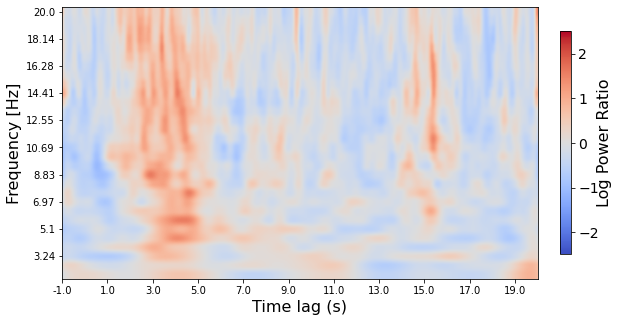

In [103]:
# chang_bh, chang_cue
dataset_power_avg = 'chang_bh'

# Load event timing
if dataset_power_avg == 'chang_bh':
    events = bh_events.copy()
    # Account for 7 TRs removed from functional
    events = events - 14.7 
elif dataset_power_avg == 'chang_cue':
    events_raw = cue_events.copy()
    # Account for 7 TRs removed from functional
    events_raw = events_raw - 14.7 
    # filter out cues that are too close together to separate 
    # hemodynamic response
    events_tr = np.round(events_raw/params['chang_cue']['tr'])
    # the cue task blocks have already been filtered using a module in run_task_avg.py
    # use the onset timing of the blocks to filter out onsets from events file
    block_filt_tr = [b[0] for b in cue_event_blocks]
    events = [e_r for e_r, e_t in zip(events_raw, events_tr) if e_t in block_filt_tr]

# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20,30)

# length of window after cue to average
event_dur = 10 # 30 seconds

# Loop through subjects and calculate evoked power
power_group = []
for subj in subj_scan_dict[dataset_power_avg]:
    # Concatenate trials across scans from the same subject
    for scan in subj_scan_dict[dataset_power_avg][subj]:
        raw = mne.io.read_raw_fif(params[dataset_power_avg]['eeg'].format(subj, scan), 
                                  preload=True, verbose=False)
        if dataset_power_avg == 'chang_bh':
            # Only average trials where the subject took a breath
            subj_compliance = compliance.loc[f'{subj}_{int(scan)}'][trial_cols]
            annot = ['BREATH' if i == 1 else 'bad BREATH' for i in subj_compliance]
        elif dataset_power_avg == 'chang_cue':
            annot = ['CUE']*len(events)
        event_annot = mne.Annotations(onset=events, duration=event_dur, description=annot)
        raw.set_annotations(event_annot)
        events_mne, event_annot = mne.events_from_annotations(raw, verbose=False)
        epochs = mne.Epochs(raw, events_mne, 1, -1, 20, reject_by_annotation = True, 
                            baseline = None, verbose=False)
        n_cycles = 15 # number of cycles parameter for wavelet
        # Morlet wavelet evoked power average
        power_avg = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
        ch_names = power_avg.ch_names
        # z-score power time courses
        power_avg.apply_baseline(baseline=(None, None), mode='zscore', verbose=False)
        # Convert to Pandas dataframe for further processing
        power_df = power_avg.to_data_frame(index=None)
        power_df['avg_chan'] = power_df[ch_names].mean(axis=1)
        power_df['freq_indx'] = power_df.groupby('freq').transform('cumcount')
        power_df['subj'] = f'{subj}_{scan}'
        power_group.append(power_df[['subj', 'time','freq','freq_indx', 'avg_chan']])

# Concatenate subject evoked power averages across subjects
power_group = pd.concat(power_group, axis=0)

# Across-subject evoked power average
power_group_avg = power_group.groupby(['freq', 'freq_indx'])['avg_chan'].mean()
power_group_avg = power_group_avg.unstack().values

# Plot 
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(power_group_avg[::-1, :], aspect=40, cmap='coolwarm', 
               vmin=-2.5, vmax=2.5)

t_sample = np.arange(0,len(times), 200)
ax.set_xticks(t_sample)
ax.set_xticklabels(times[t_sample])
ax.set_xlabel('Time lag (s)', fontsize=16)

freq_sample = np.arange(0,len(freqs),3)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[::-1][freq_sample],2))
ax.set_ylabel('Frequency [Hz]', fontsize=16)
cbar = plt.colorbar(im,fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Log Power Ratio', fontsize=16, labelpad=-2)

plt.show()

## 4.2 NKI Breath-Hold Task

### 4.2.1 Scan Average

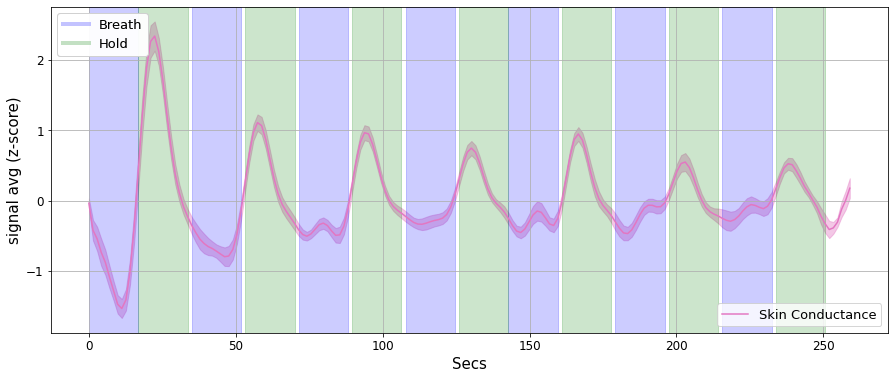

In [132]:
physio_select = ['GSR']

physio_labels = [physio_label_dict[p] for p in physio_select]

# load nki events and convert to blocks
nki_events = load_nki_event_file()
nki_blocks = construct_task_blocks('nki', nki_events, 0)
breath_indx = np.concatenate(nki_blocks[0][1])
hold_indx = np.concatenate(nki_blocks[1][1])

physio_list = [[] for i in range(len(physio_select))]
subject, scan = load_subject_list('nki', params['nki']['subject_list'])
for subj, sc in zip(subject, scan):
    df = load_subj(subj, sc, 'nki', params['nki'], pca_dict['nki'][f'{subj}_{sc}'], 
                   pca_index=0)
    for i, p in enumerate(physio_select):
        if p == 'PC1':
            p_sig = zscore(df[p].values)[:,np.newaxis]*pca_sign_dict['nki']
        else:
            p_sig = zscore(df[p].values)[:,np.newaxis]
        physio_list[i].append(zscore(df[p].values))

physio_avg_list = [np.mean(physio_list[i], axis=0) for i in range(len(physio_select))]

n_t = len(physio_avg_list[0])
fs_nki = 1/params['nki']['tr']
n_secs = np.arange(n_t)/fs_nki

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])

physio_se_list = []
for i, p in enumerate(physio_list):
    # the np.array call with dtype parameter because the 'object' dtype is carried forward
    # from physio_array
    perms_se = np.vstack([np.array(perm_i[i], dtype='float') for perm_i in perms_avg])
    physio_se_list.append(np.std(perms_se, axis=0))
    
fig, ax = plt.subplots(figsize=(15,6))
for i, (p_avg, p_se, p) in enumerate(zip(physio_avg_list, physio_se_list, physio_select)):
    ax.plot(n_secs, p_avg, color=color_dict[p])
    ax.fill_between(n_secs, p_avg-p_se, p_avg+p_se, alpha=0.4, color=color_dict[p])


lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(len(physio_select))], 
                     physio_labels, 
                     loc=4, fontsize=13)

trial_labels = ['breath', 'hold']
trial_colors = ['blue', 'green']
# Use trial timing from last subject trial timing
for i, trial in enumerate(trial_labels):
    if trial == 'breath':
        blocks = breath_indx
    elif trial == 'hold':
        blocks = hold_indx
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b)/fs_nki, max(b)/fs_nki, alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Breath', 'Hold'], loc=2, fontsize=13)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('Secs', fontsize=15)
ax.set_ylabel('signal avg (z-score)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

### 4.2.2 Trial Average

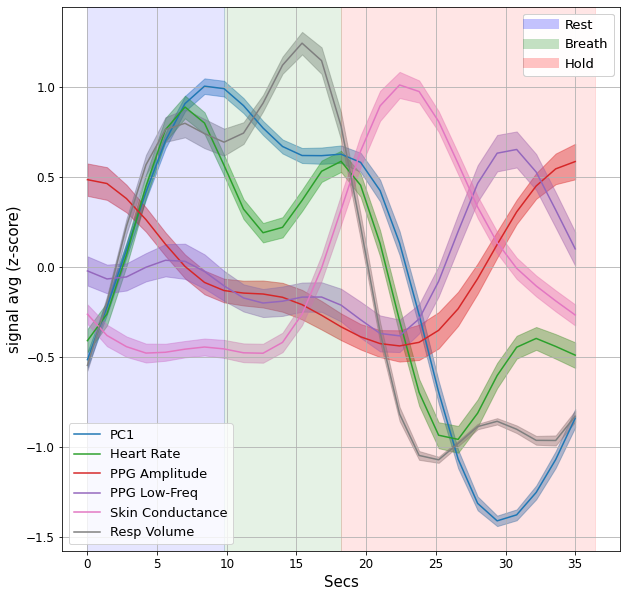

In [133]:
physio_select = ['PC1', 'PPG_HR', 'PPG_PEAK_AMP', 'PPG_LOW', 'GSR', 'RSP_RVT']

physio_labels = [physio_label_dict[p] for p in physio_select]

# load nki events and convert to blocks
nki_events = load_nki_event_file()
nki_events['block'] = (nki_events['trial_type'] == 'R').cumsum()
group_func = {'onset': 'first', 'duration': 'sum'}
block_df = nki_events.groupby('block').agg(group_func)
block_indx = onsets_to_block(block_df, params['nki']['tr'], 0)

# set block type indices
rest_dur = np.round(10/params['nki']['tr'])
breath_dur = np.round(8/params['nki']['tr'])
hold_dur = np.round(18/params['nki']['tr'])
rest_block = np.arange(rest_dur).astype(int)
breath_block = np.arange(rest_dur, rest_dur + breath_dur).astype(int)
rest_breath_dur = rest_dur + breath_dur
hold_block = np.arange(rest_breath_dur, rest_breath_dur + hold_dur).astype(int)

physio_list = [[] for i in range(len(physio_select))]
subject, scan = load_subject_list('nki', params['nki']['subject_list'])
for subj, sc in zip(subject, scan):
    df = load_subj(subj, sc, 'nki', params['nki'], pca_dict['nki'][f'{subj}_{sc}'], 
                   pca_index=0)
    for i, p in enumerate(physio_select):
        if p == 'PC1':
            p_sig = zscore(df[p].values)[:,np.newaxis]*pca_sign_dict['nki']
        else:
            p_sig = zscore(df[p].values)[:,np.newaxis]
        p_sig_avg = np.squeeze(p_sig[block_indx,:].mean(axis=0))
        physio_list[i].append(p_sig_avg)

physio_avg_list = [np.mean(physio_list[i], axis=0) for i in range(len(physio_select))]

n_t = len(physio_avg_list[0])
fs_nki = 1/params['nki']['tr']
n_secs = np.arange(n_t)/fs_nki

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])

physio_se_list = []
for i, p in enumerate(physio_list):
    # the np.array call with dtype parameter because the 'object' dtype is carried forward
    # from physio_array
    perms_se = np.vstack([np.array(perm_i[i], dtype='float') for perm_i in perms_avg])
    physio_se_list.append(np.std(perms_se, axis=0))
    
fig, ax = plt.subplots(figsize=(10,10))
for i, (p_avg, p_se, p) in enumerate(zip(physio_avg_list, physio_se_list, physio_select)):
    ax.plot(n_secs, p_avg, color=color_dict[p])
    ax.fill_between(n_secs, p_avg-p_se, p_avg+p_se, alpha=0.4, color=color_dict[p])


lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(len(physio_select))], 
                     physio_labels, loc='lower left', fontsize=13)

trial_labels = ['rest', 'breath', 'hold']
trial_colors = ['blue', 'green', 'red']
# Use trial timing from last subject trial timing
for i, trial in enumerate(trial_labels):
    if trial == 'rest':
        blocks = rest_block
    elif trial == 'breath':
        blocks = breath_block
    elif trial == 'hold':
        blocks = hold_block
    ax.axvspan(n_secs[blocks[0]], n_secs[blocks[-1]]+params['nki']['tr'], 
               alpha=0.1, color=trial_colors[i])

trial_leg_labels = [
    Line2D([0], [0], color='blue', lw=10, alpha=0.2),                
    Line2D([0], [0], color='green', lw=10, alpha=0.2),
    Line2D([0], [0], color='red', lw=10, alpha=0.2)
]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], 
                     loc='upper right', fontsize=13)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('Secs', fontsize=15)
ax.set_ylabel('signal avg (z-score)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

# 5. Commonality Analysis of Spontaneous Respiration Rate and Depth

chang
hcp
spreng


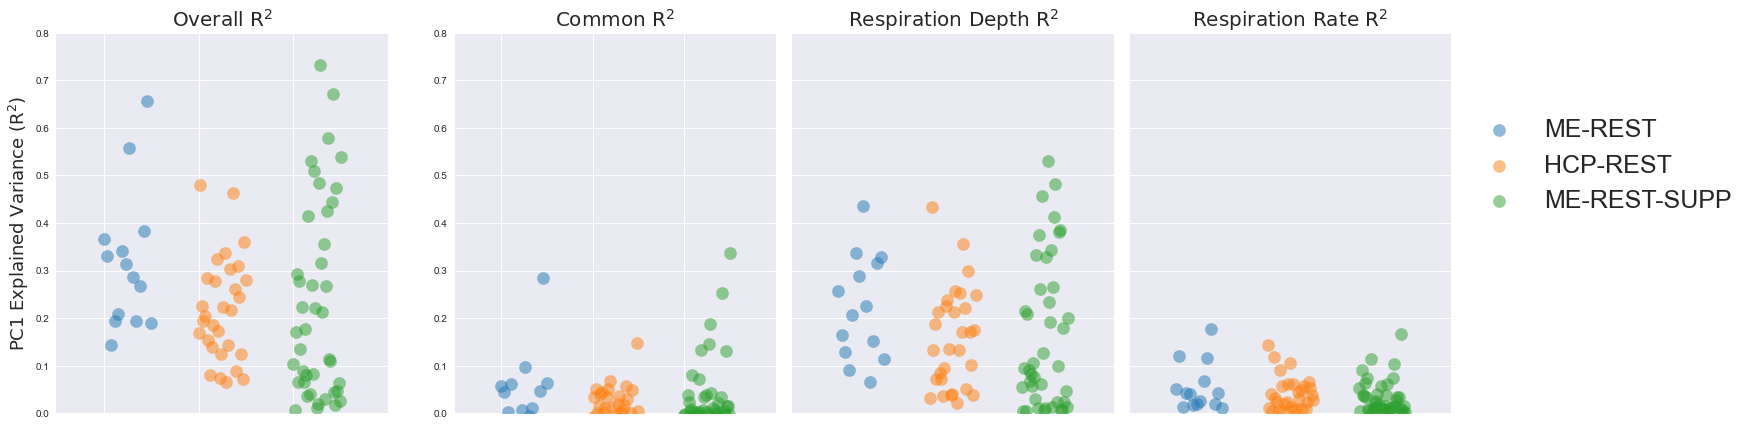

In [201]:
# Regression (Spline) Parameters  
lag_vec_dict = {
    'chang': np.arange(5),
    'hcp': np.arange(14),
    'spreng': np.arange(4),
    'nki_rest': np.arange(10)
}   
df_spline=3

# Initialize result lists
full_r2_all = []
common_r2_all = []
unique_r2_all = []

datasets = ['chang', 'hcp', 'spreng', 'nki_rest']

# Loop through dataset and run commonality analysis
for d in datasets:
    subj_list = subj_dict[d]
    data_load = data_load_dict[d]
    lag_vec = lag_vec_dict[d]
    full_r2_d = []
    common_r2_d = []
    unique_r2_d = {
    'RESP AMP': [],
    'RESP RATE': [],
    }
    for i in range(subj_list.shape[0]):
        # Load Subject
        if d == 'chang':
            subj, scan = int(subj_list.iloc[i]['subject']), int(subj_list.iloc[i]['scan'])
            df = data_load(subj, scan, pca_dict[d][0][f'{subj}_{scan}'], 
                           pca_dict[d][1][f'{subj}_{scan}'], sf_dict[d])
        else:
            subj = subj_list.iloc[i]['subject']
            df = data_load(subj, pca_dict[d][0][f'{subj}'], 
                           pca_dict[d][1][f'{subj}'], sf_dict[d])
            
        # Create lag spline bases for physio time series
        rv_amp_basis, lag_spline = lag_basis(df['RESP_RVT_AMP_NK'], lag_vec, df_spline)
        rv_rate_basis, lag_spline = lag_basis(df['RESP_RVT_IF_NK'], lag_vec, df_spline)
        # Drop NaNs at beginning of time series introduced by lag, and then normalize
        na_indx = ~(np.isnan(rv_amp_basis).any(axis=1))
        pred_list = [rv_amp_basis[na_indx, :], rv_rate_basis[na_indx,:]]
        # Create full design matrix
        full_basis = np.hstack(pred_list)

        # Get PC time course
        pc_ts = zscore(df['pc1'].loc[na_indx].values)

        # Run commonality analysis
        pred_label = ['RESP AMP', 'RESP RATE']
        pred_label_col_indx = ([0]*df_spline) + ([1]*df_spline) 
        full_r2, common_r2, unique_r2 = commonality_analysis(pc_ts, full_basis, pred_label, pred_label_col_indx)

        # Append results to dataset list 
        full_r2_d.append(full_r2)
        common_r2_d.append(common_r2)
        for label in pred_label:
            unique_r2_d[label].append(unique_r2[label])
    # Append dataset list to overall results list
    full_r2_all.append(full_r2_d)
    common_r2_all.append(common_r2_d)
    unique_r2_all.append(unique_r2_d)

# Visualize results
cmap = cm.get_cmap('tab10')

with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(25,7), constrained_layout=False)
    gspec = fig.add_gridspec(1,2, wspace=0.1, width_ratios=[0.25, 0.75])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gspec[0])
    g_sub2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gspec[1], wspace=0.05)
    
    ax = fig.add_subplot(g_sub1[0])
    ax.scatter(np.linspace(0,1,len(full_r2_all[0])), full_r2_all[0], s=150, alpha=0.5, 
               color=cmap(0))
    ax.scatter(np.linspace(0,1,len(full_r2_all[1]))+2, full_r2_all[1], s=150, alpha=0.5, 
               color=cmap(1))
    ax.scatter(np.linspace(0,1,len(full_r2_all[2]))+4, full_r2_all[2], s=150, alpha=0.5, 
               color=cmap(2))
    ax.set_ylim([0,0.8])
    ax.set_xlim([-1,6])
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
    ax.xaxis.set_ticklabels([])
    ax.set_title('Overall $R^2$', fontweight='bold', fontsize=20)
    ax.set_ylabel('PC1 Explained Variance ($R^2$)', fontsize=18)
    
    ax = fig.add_subplot(g_sub2[0])
    ax.scatter(np.linspace(0,1,len(common_r2_all[0])), common_r2_all[0], s=150, alpha=0.5, 
               color=cmap(0))
    ax.scatter(np.linspace(0,1,len(common_r2_all[1]))+2, common_r2_all[1], s=150, alpha=0.5, 
               color=cmap(1))
    ax.scatter(np.linspace(0,1,len(common_r2_all[2]))+4, common_r2_all[2], s=150, alpha=0.5, 
               color=cmap(2))
    ax.set_ylim([0,0.8])
    ax.set_xlim([-1,6])
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
    ax.xaxis.set_ticklabels([])
    ax.set_title('Common $R^2$', fontweight='bold', fontsize=20)

    ax = fig.add_subplot(g_sub2[1])
    ax.scatter(np.linspace(0,1,len(unique_r2_all[0]['RESP AMP'])), unique_r2_all[0]['RESP AMP'], 
               s=150, alpha=0.5, color=cmap(0))
    ax.scatter(np.linspace(0,1,len(unique_r2_all[1]['RESP AMP']))+2, unique_r2_all[1]['RESP AMP'], 
               s=150, alpha=0.5, color=cmap(1))
    ax.scatter(np.linspace(0,1,len(unique_r2_all[2]['RESP AMP']))+4, unique_r2_all[2]['RESP AMP'], 
               s=150, alpha=0.5, color=cmap(2))
    ax.set_ylim([0,0.8])
    ax.set_xlim([-1,6])
    ax.set_xticks([])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Respiration Depth $R^2$', fontweight='bold', fontsize=20)
    
    ax = fig.add_subplot(g_sub2[2])
    lin1 = ax.scatter(np.linspace(0,1,len(unique_r2_all[0]['RESP RATE'])), unique_r2_all[0]['RESP RATE'], 
               s=150, alpha=0.5, color=cmap(0), label='ME-REST')
    lin2 = ax.scatter(np.linspace(0,1,len(unique_r2_all[1]['RESP RATE']))+2, unique_r2_all[1]['RESP RATE'], 
               s=150, alpha=0.5, color=cmap(1), label='HCP-REST')
    lin3 = ax.scatter(np.linspace(0,1,len(unique_r2_all[2]['RESP RATE']))+4, unique_r2_all[2]['RESP RATE'], 
               s=150, alpha=0.5, color=cmap(2), label='ME-REST-SUPP')
    ax.set_ylim([0,0.8])
    ax.set_xlim([-1,6])
    ax.set_xticks([])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Respiration Rate $R^2$', fontweight='bold', fontsize=20)

    plt.legend(loc=(1.04, 0.5), fontsize=25)

    plt.show()


# 8. Supplementary

## 8.1 PPG Power Spectral Density

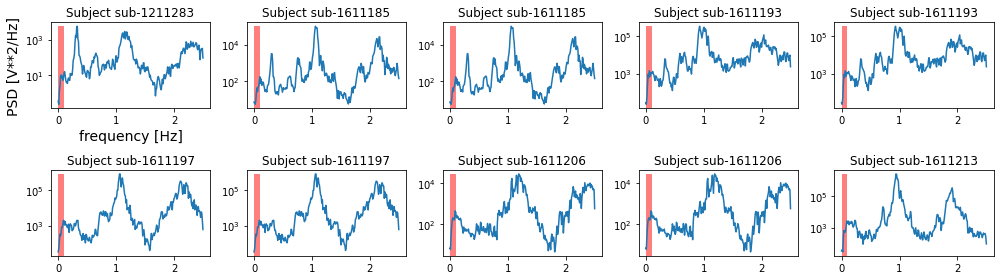

In [5]:
datasets_list = ['chang', 'chang_bh', 'hcp', 'nki', 'spreng']
dataset_subjects = [subject_list_chang, subject_list_chang_bh, 
                    subject_list_hcp, subject_list_nki, subject_list_spreng]
sf_resamp = 5 # resampling rate before power spectral density estimate

dataset = 'spreng' # provide string of dataset

subject_list = dataset_subjects[datasets_list.index(dataset)]
# Limit to 10 subjects for larger datasets
subject_list = subject_list.iloc[:10,:].copy()

fig, axs = plt.subplots(2,5, figsize=(14,4))
for i, ax in zip(range(subject_list.shape[0]), axs.flat):
    if (dataset == 'chang') | (dataset == 'chang_bh'):
        subj, scan = subject_list.iloc[i,:][['subject', 'scan']].astype(int)
        physio = load_raw_physio(subj, dataset, fs_resamp=sf_resamp, scan=scan)
    elif dataset == 'nki':
        subj = subject_list.iloc[i,:]['subject']
        physio = load_raw_physio(subj, dataset, fs_resamp=sf_resamp)
    elif dataset == 'hcp':
        subj, scan = subject_list.iloc[i,:][['subject', 'lr']]
        hcp_sf_physio = 400
        physio = load_raw_physio(subj, dataset, fs=hcp_sf_physio, fs_resamp=sf_resamp, scan=scan)
    elif dataset == 'spreng':
        subj, scan = subject_list.iloc[i,:][['subject', 'scan']]
        physio = load_raw_physio(subj, dataset, fs_resamp=sf_resamp, scan=scan)

    f, pxx = welch(physio['ppg'], 5, nperseg=500, noverlap=50)
    ax.semilogy(f, pxx)
    if (dataset == 'chang') | (dataset == 'chang_bh'):
        ax.set_title(f'Subject {subj} - Scan {scan}', fontsize=12)
    else:
        ax.set_title(f'Subject {subj}', fontsize=12)

    if i == 0:
        ax.set_xlabel('frequency [Hz]', fontsize=14)
        ax.set_ylabel('PSD [V**2/Hz]', fontsize=14)
    f_low = f[f <= 0.1]
    ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)

fig.tight_layout()
plt.show()

## 8.2 PCA Explaned Variance Across Datasets 

### 8.2.1 Standard PCA

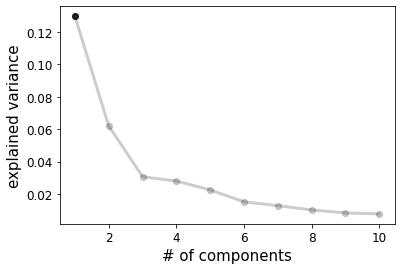

In [144]:
pca_results = [
    'results/pca/chang_pca_results.pkl',
    'results/pca/chang_bh_pca_results.pkl',
    'results/pca/hcp_pca_results.pkl',
    'results/pca/nki_pca_results.pkl',
    'results/pca/nki_rest_pca_results.pkl',
    'results/pca/spreng_pca_results.pkl',
    'results/pca/yale_pca_results.pkl'
]

exp_var_all = []
for res in pca_results:
    res_tmp = pickle.load(open(res, 'rb'))
    exp_var_all.append(res_tmp['exp_var'])

fig, ax = plt.subplots()

# Select Dataset
e = exp_var_all[6]

ax.plot([1], e[0], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(1, 11), e[:11], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



### 8.2.2 Complex PCA

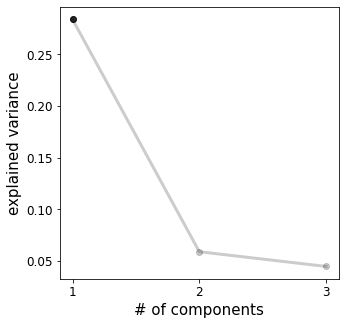

In [14]:
pca_results = [
    'results/cpca/chang_pca_group_c_results.pkl',
    'results/cpca/chang_bh_pca_group_c_results.pkl',
    'results/cpca/hcp_fix_pca_group_c_results.pkl',
    'results/cpca/nki_pca_group_c_results.pkl',
    'results/cpca/spreng_pca_group_c_results.pkl',
    'results/cpca/yale_pca_group_c_results.pkl'
]

exp_var_all = []
for res in pca_results:
    res_tmp = pickle.load(open(res, 'rb'))
    exp_var_all.append(res_tmp['exp_var'])

fig, ax = plt.subplots(figsize=(5,5))

# Select Dataset
e = exp_var_all[5]

ax.plot([1], e[0], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(1, 4), e[:3], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_xticks(np.arange(1,4))
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



## 8.3 Subject Time Courses

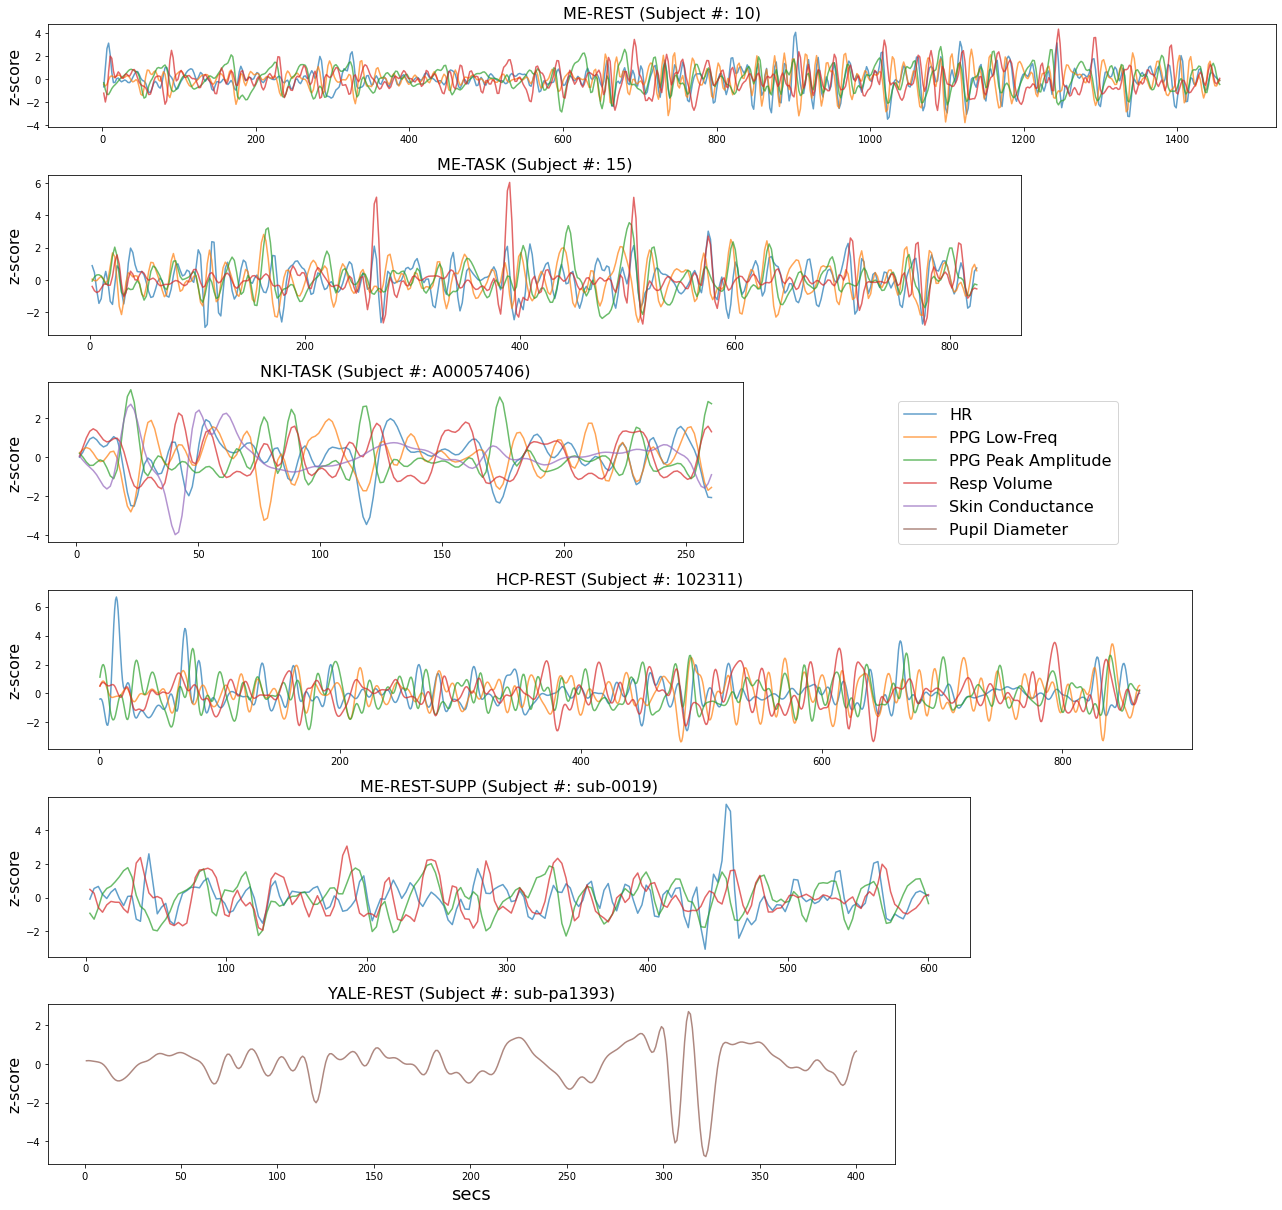

In [113]:
physio_dict = {
    'chang': ['PPG_HR_NK', 'PPG_LOW_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'chang_bh': ['PPG_HR_NK', 'PPG_LOW_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'nki': ['PPG_HR_NK', 'PPG_LOW_NK' ,'PPG_PEAK_AMP', 'RESP_RVT_NK', 'GSR'],
    'hcp': ['PPG_HR_NK', 'PPG_LOW_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'spreng': ['PPG_HR_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'yale': ['pupil']
}

dataset_aspect_dict = {
    'chang': 15,
    'chang_bh': 15,
    'nki': 8,
    'hcp': 12,
    'spreng': 12,
    'yale': 10
}

fig = plt.figure(figsize=(22,22), constrained_layout=False)
gspec = fig.add_gridspec(6,1, hspace=0.3, height_ratios=None)

cmap = plt.get_cmap('tab10')

physio_color_dict = {
    'PPG_HR_NK': cmap(0),
    'PPG_LOW_NK': cmap(1),
    'PPG_PEAK_AMP': cmap(2),
    'RESP_RVT_NK': cmap(3),
    'GSR': cmap(4),
    'pupil': cmap(5)
}

subj_indx = 0
for i, d in enumerate(subj_dict):
    subj_list = subj_dict[d]
    if d in ['chang', 'chang_bh', 'yale']:
        if d in ['chang', 'chang_bh']:
            subj, scan = int(subj_list.iloc[i]['subject']), int(subj_list.iloc[i]['scan'])
        elif d == 'yale':
            subj, scan = subj_list.iloc[i]['subject'], int(subj_list.iloc[i]['scan'])
            
        df_subj = data_load_dict[d](subj, scan, pca_dict[d][0][f'{subj}_{scan}'], 
                                    pca_dict[d][1][f'{subj}_{scan}'], sf_dict[d])
    else:
        subj = subj_list.iloc[subj_indx,:]['subject']
        df_subj = data_load_dict[d](subj, pca_dict[d][0][f'{subj}'], 
                                    pca_dict[d][1][f'{subj}'], sf_dict[d])

    ax = fig.add_subplot(gspec[i])
    ax.set_aspect(dataset_aspect_dict[d], anchor='SW')
    
    x = np.arange(1, df_subj.shape[0]+1)*(1/sf_dict[d])
    for p in physio_dict[d]:
        ax.plot(x, df_subj[p], color=physio_color_dict[p], alpha=0.7, label=physio_label_dict[p])
        
    ax.set_title(f'{label_dict[d]} (Subject #: {subj})', fontsize=16)
    ax.set_ylabel('z-score', fontsize=16)
    if i == 5:
        ax.set_xlabel('secs', fontsize=18)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines = []
labels = []
label_list = []
for ax_lines in lines_labels:
    for line, label in zip(*ax_lines):
        if label not in label_list:
            lines.append(line)
            labels.append(label)
            label_list.append(label)
# Finally, we invoke the legend (that you probably would like to customize...)
fig.legend(lines, labels, loc = (0.7,0.55), fontsize=16,
           bbox_transform = plt.gcf().transFigure)


## 8.4 Electrophysiological Preprocessing Flow Chart

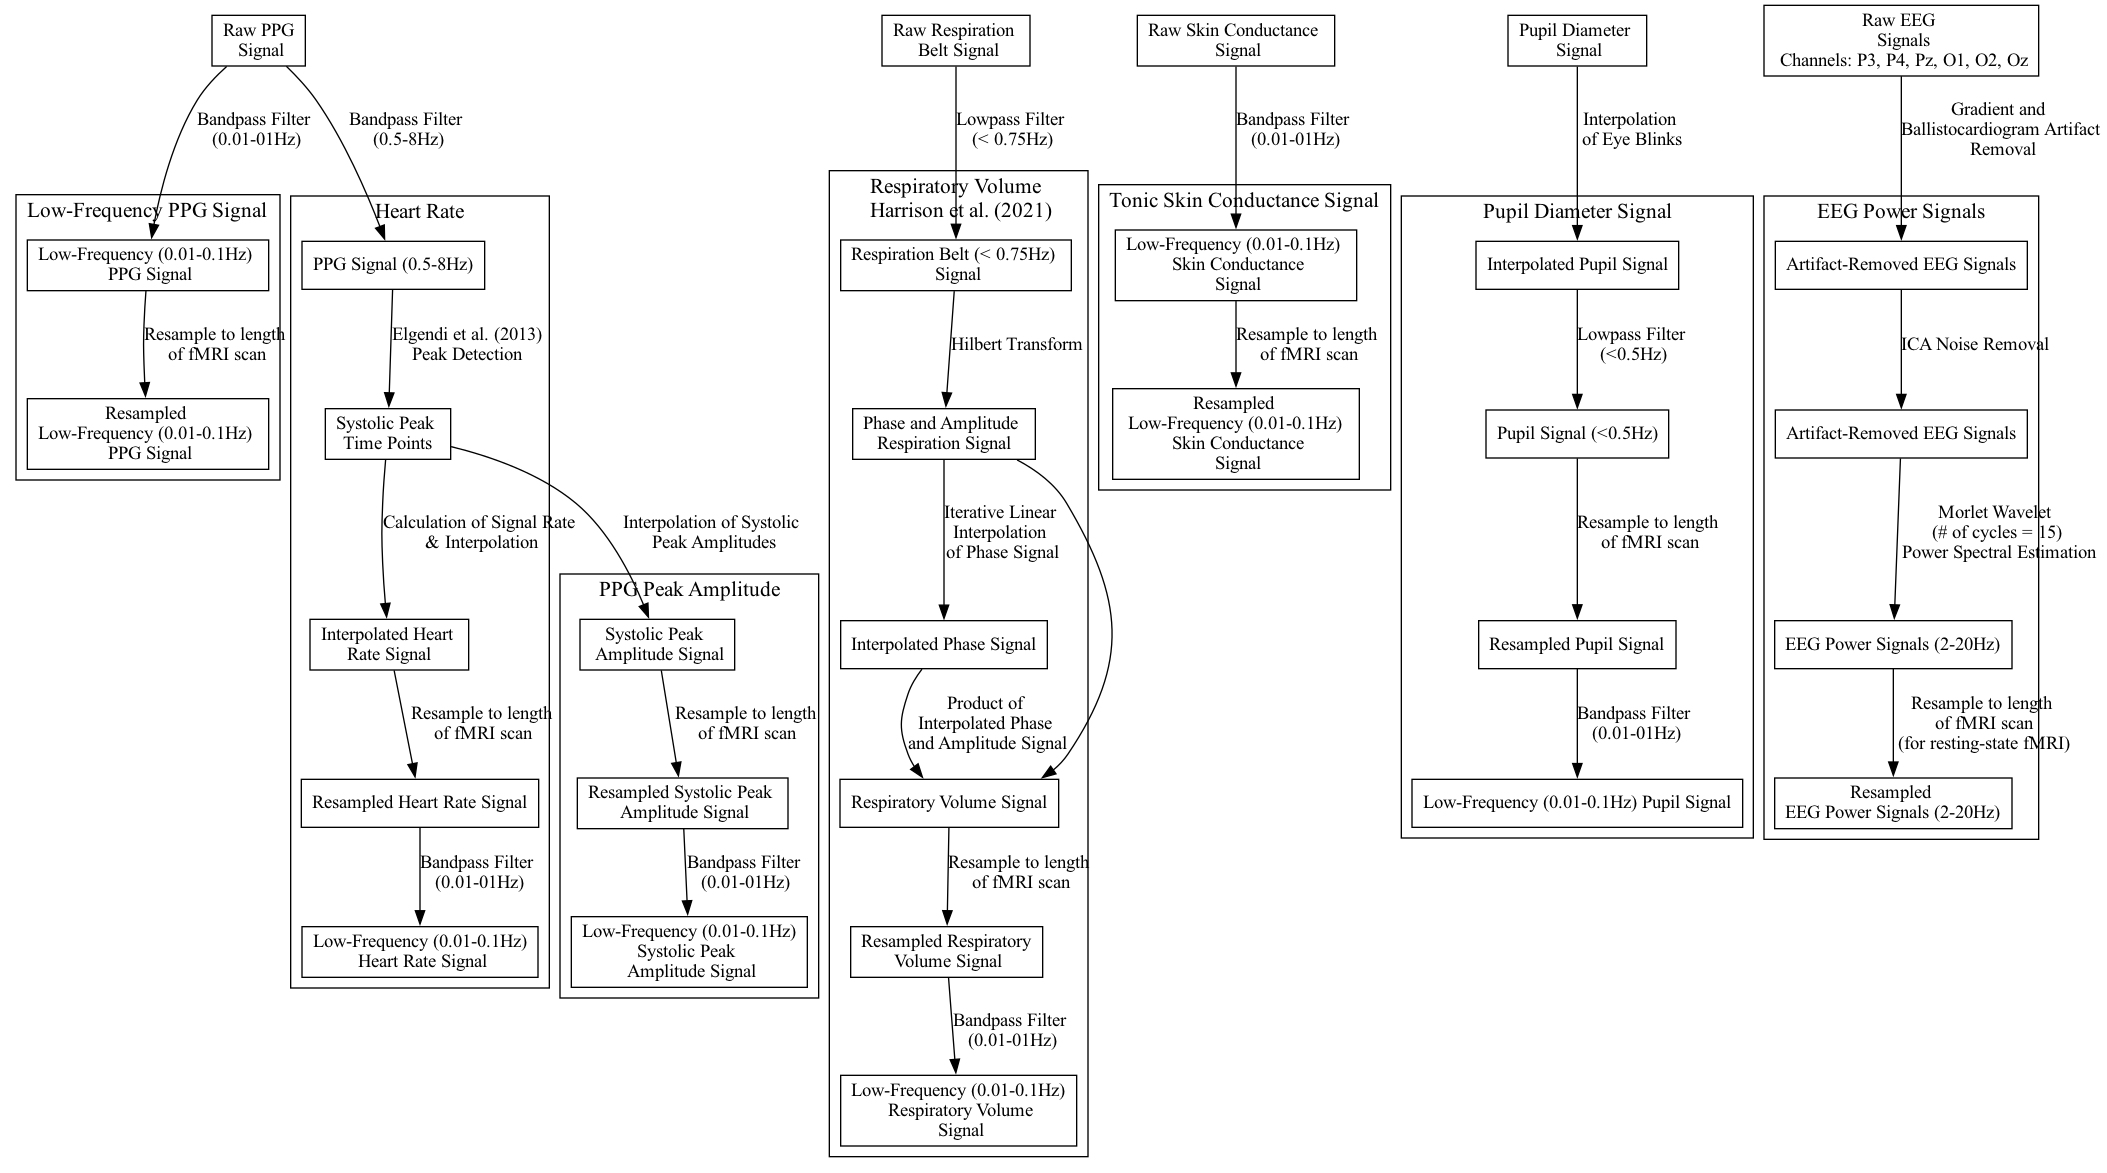

In [89]:
# The Pydot (pydot==1.4.2) package is not in the requirements.txt file, it's only needed for the following
# flowchart graphic
import pydot

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
    
dot_graph = pydot.Dot(graph_type='digraph')

# Raw Signal Nodes
ppg_node = pydot.Node('RAW_PPG', label='Raw PPG\n Signal')
ppg_node.set_shape('box')
dot_graph.add_node(ppg_node)

resp_node = pydot.Node('RAW_RESP', label='Raw Respiration \n Belt Signal')
resp_node.set_shape('box')
dot_graph.add_node(resp_node)

gsr_node = pydot.Node('RAW_GSR', label='Raw Skin Conductance \n Signal')
gsr_node.set_shape('box')
dot_graph.add_node(gsr_node)

pupil_node = pydot.Node('RAW_PUPIL', label='Pupil Diameter \n Signal')
pupil_node.set_shape('box')
dot_graph.add_node(pupil_node)

eeg_node = pydot.Node('RAW_EEG', label='Raw EEG \n Signals\n Channels: P3, P4, Pz, O1, O2, Oz')
eeg_node.set_shape('box')
dot_graph.add_node(eeg_node)


# Put separate pipelines into clusters
ppg_low_cluster=pydot.Cluster('PPG_LOW_CLUS', label='Low-Frequency PPG Signal', 
                              shape='rectangle', fontsize=16)
dot_graph.add_subgraph(ppg_low_cluster)

hr_cluster=pydot.Cluster('HR', label='Heart Rate',shape='rectangle', fontsize=16)
dot_graph.add_subgraph(hr_cluster)

ppg_amp_cluster=pydot.Cluster('PPG_PEAK', label='PPG Peak Amplitude', shape='rectangle', fontsize=16)
dot_graph.add_subgraph(ppg_amp_cluster)

resp_cluster=pydot.Cluster('RESP', label='Respiratory Volume \n Harrison et al. (2021)',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(resp_cluster)

gsr_cluster=pydot.Cluster('GSR', label='Tonic Skin Conductance Signal',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(gsr_cluster)

pupil_cluster=pydot.Cluster('PUPIL', label='Pupil Diameter Signal',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(pupil_cluster)

eeg_cluster=pydot.Cluster('EEG', label='EEG Power Signals',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(eeg_cluster)

# First Preprocessing Nodes
ppg_low_node = pydot.Node('PPG_LOW', label='Low-Frequency (0.01-0.1Hz) \n PPG Signal')
ppg_low_node.set_shape('box')
ppg_low_cluster.add_node(ppg_low_node)
ppg_edge_low = pydot.Edge('RAW_PPG', 'PPG_LOW', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_edge_low)

ppg_proc1_node = pydot.Node('PROC1_PPG', label='PPG Signal (0.5-8Hz)')
ppg_proc1_node.set_shape('box')
hr_cluster.add_node(ppg_proc1_node)
ppg_edge1 = pydot.Edge('RAW_PPG', 'PROC1_PPG', label='Bandpass Filter \n(0.5-8Hz)')
dot_graph.add_edge(ppg_edge1)

resp_proc1_node = pydot.Node('PROC1_RESP', label='Respiration Belt (< 0.75Hz) \n Signal')
resp_proc1_node.set_shape('box')
resp_cluster.add_node(resp_proc1_node)
resp_edge1 = pydot.Edge('RAW_RESP', 'PROC1_RESP', label='Lowpass Filter \n(< 0.75Hz)')
dot_graph.add_edge(resp_edge1)

gsr_proc1_node = pydot.Node('PROC1_GSR', label='Low-Frequency (0.01-0.1Hz) \n Skin Conductance\n Signal')
gsr_proc1_node.set_shape('box')
gsr_cluster.add_node(gsr_proc1_node)
gsr_edge1 = pydot.Edge('RAW_GSR', 'PROC1_GSR', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(gsr_edge1)

pupil_proc1_node = pydot.Node('PROC1_PUPIL', label='Interpolated Pupil Signal')
pupil_proc1_node.set_shape('box')
pupil_cluster.add_node(pupil_proc1_node)
pupil_edge1 = pydot.Edge('RAW_PUPIL', 'PROC1_PUPIL', label='Interpolation\n of Eye Blinks')
dot_graph.add_edge(pupil_edge1)

eeg_proc1_node = pydot.Node('PROC1_EEG', label='Artifact-Removed EEG Signals')
eeg_proc1_node.set_shape('box')
eeg_cluster.add_node(eeg_proc1_node)
eeg_edge1 = pydot.Edge('RAW_EEG', 'PROC1_EEG', label='Gradient and \nBallistocardiogram Artifact\n Removal')
dot_graph.add_edge(eeg_edge1)

# Second Preprocessing Nodes
ppg_proc2_node = pydot.Node('PROC2_PPG', label='Systolic Peak \nTime Points')
ppg_proc2_node.set_shape('box')
hr_cluster.add_node(ppg_proc2_node)
ppg_edge2 = pydot.Edge('PROC1_PPG', 'PROC2_PPG', label='Elgendi et al. (2013)\nPeak Detection')
dot_graph.add_edge(ppg_edge2)

ppg_low_proc1_node = pydot.Node('PROC1_PPG_LOW', label='Resampled \nLow-Frequency (0.01-0.1Hz) \n PPG Signal')
ppg_low_proc1_node.set_shape('box')
ppg_low_cluster.add_node(ppg_low_proc1_node)
ppg_edge_low2 = pydot.Edge('PPG_LOW', 'PROC1_PPG_LOW', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_edge_low2)

resp_proc2_node = pydot.Node('PROC2_RESP', label='Phase and Amplitude \nRespiration Signal')
resp_proc2_node.set_shape('box')
resp_cluster.add_node(resp_proc2_node)
resp_edge2 = pydot.Edge('PROC1_RESP', 'PROC2_RESP', label='Hilbert Transform')
dot_graph.add_edge(resp_edge2)

gsr_proc2_node = pydot.Node('PROC2_GSR', label='Resampled \n Low-Frequency (0.01-0.1Hz) \n Skin Conductance\n Signal')
gsr_proc2_node.set_shape('box')
gsr_cluster.add_node(gsr_proc2_node)
gsr_edge2 = pydot.Edge('PROC1_GSR', 'PROC2_GSR', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(gsr_edge2)

pupil_proc2_node = pydot.Node('PROC2_PUPIL', label='Pupil Signal (<0.5Hz)')
pupil_proc2_node.set_shape('box')
pupil_cluster.add_node(pupil_proc2_node)
pupil_edge2 = pydot.Edge('PROC1_PUPIL', 'PROC2_PUPIL', label='Lowpass Filter\n (<0.5Hz)')
dot_graph.add_edge(pupil_edge2)

eeg_proc2_node = pydot.Node('PROC2_EEG', label='Artifact-Removed EEG Signals')
eeg_proc2_node.set_shape('box')
eeg_cluster.add_node(eeg_proc2_node)
eeg_edge2 = pydot.Edge('PROC1_EEG', 'PROC2_EEG', label='ICA Noise Removal')
dot_graph.add_edge(eeg_edge2)

# Third Preprocessing Nodes
ppg_proc3_node = pydot.Node('PROC3_PPG', label='Interpolated Heart \nRate Signal')
ppg_proc3_node.set_shape('box')
hr_cluster.add_node(ppg_proc3_node)
ppg_edge3 = pydot.Edge('PROC2_PPG', 'PROC3_PPG', label='Calculation of Signal Rate\n & Interpolation')
dot_graph.add_edge(ppg_edge3)

ppg_amp_proc3_node = pydot.Node('PROC3_AMP_PPG', label='Systolic Peak \n Amplitude Signal')
ppg_amp_proc3_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc3_node)
ppg_amp_edge3 = pydot.Edge('PROC2_PPG', 'PROC3_AMP_PPG', label='Interpolation of Systolic\n Peak Amplitudes')
dot_graph.add_edge(ppg_amp_edge3)

resp_proc3_node = pydot.Node('PROC3_RESP', label='Interpolated Phase Signal')
resp_proc3_node.set_shape('box')
resp_cluster.add_node(resp_proc3_node)
resp_edge3 = pydot.Edge('PROC2_RESP', 'PROC3_RESP', label='Iterative Linear \nInterpolation \nof Phase Signal')
dot_graph.add_edge(resp_edge3)

pupil_proc3_node = pydot.Node('PROC3_PUPIL', label='Resampled Pupil Signal')
pupil_proc3_node.set_shape('box')
pupil_cluster.add_node(pupil_proc3_node)
pupil_edge3 = pydot.Edge('PROC2_PUPIL', 'PROC3_PUPIL', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(pupil_edge3)

eeg_proc3_node = pydot.Node('PROC3_EEG', label='EEG Power Signals (2-20Hz)')
eeg_proc3_node.set_shape('box')
eeg_cluster.add_node(eeg_proc3_node)
eeg_edge3 = pydot.Edge('PROC2_EEG', 'PROC3_EEG', label='Morlet Wavelet \n(# of cycles = 15)\n Power Spectral Estimation')
dot_graph.add_edge(eeg_edge3)

# Fourth Preprocessing Nodes
ppg_proc4_node = pydot.Node('PROC4_PPG', label='Resampled Heart Rate Signal')
ppg_proc4_node.set_shape('box')
hr_cluster.add_node(ppg_proc4_node)
ppg_edge4 = pydot.Edge('PROC3_PPG', 'PROC4_PPG', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_edge4)

ppg_amp_proc4_node = pydot.Node('PROC4_AMP_PPG', label='Resampled Systolic Peak \n Amplitude Signal')
ppg_amp_proc4_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc4_node)
ppg_amp_edge4 = pydot.Edge('PROC3_AMP_PPG', 'PROC4_AMP_PPG', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_amp_edge4)

resp_proc4_node = pydot.Node('PROC4_RESP', label='Respiratory Volume Signal')
resp_proc4_node.set_shape('box')
resp_cluster.add_node(resp_proc4_node)
resp_edge4_1 = pydot.Edge('PROC3_RESP', 'PROC4_RESP', 
                        label='Product of \nInterpolated Phase \nand Amplitude Signal')
resp_edge4_2 = pydot.Edge('PROC2_RESP', 'PROC4_RESP')
dot_graph.add_edge(resp_edge4_1)
dot_graph.add_edge(resp_edge4_2)

pupil_proc4_node = pydot.Node('PROC4_PUPIL', label='Low-Frequency (0.01-0.1Hz) Pupil Signal')
pupil_proc4_node.set_shape('box')
pupil_cluster.add_node(pupil_proc4_node)
pupil_edge4 = pydot.Edge('PROC3_PUPIL', 'PROC4_PUPIL', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(pupil_edge4)

eeg_proc4_node = pydot.Node('PROC4_EEG', label='Resampled \nEEG Power Signals (2-20Hz)')
eeg_proc4_node.set_shape('box')
eeg_cluster.add_node(eeg_proc4_node)
eeg_edge4 = pydot.Edge('PROC3_EEG', 'PROC4_EEG', 
                       label='Resample to length\n of fMRI scan\n (for resting-state fMRI)')
dot_graph.add_edge(eeg_edge4)

# Fifth Preprocessing Nodes
ppg_proc5_node = pydot.Node('PROC5_PPG', label='Low-Frequency (0.01-0.1Hz)\n Heart Rate Signal')
ppg_proc5_node.set_shape('box')
hr_cluster.add_node(ppg_proc5_node)
ppg_edge5 = pydot.Edge('PROC4_PPG', 'PROC5_PPG', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_edge5)

ppg_amp_proc5_node = pydot.Node('PROC5_AMP_PPG', label='Low-Frequency (0.01-0.1Hz)\nSystolic Peak \n Amplitude Signal')
ppg_amp_proc5_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc5_node)
ppg_amp_edge5 = pydot.Edge('PROC4_AMP_PPG', 'PROC5_AMP_PPG', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_amp_edge5)

resp_proc5_node = pydot.Node('PROC5_RESP', label='Resampled Respiratory\n Volume Signal')
resp_proc5_node.set_shape('box')
resp_cluster.add_node(resp_proc5_node)
resp_edge5 = pydot.Edge('PROC4_RESP', 'PROC5_RESP', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(resp_edge5)

# Sixth Preprocessing Node
resp_proc6_node = pydot.Node('PROC6_RESP', label='Low-Frequency (0.01-0.1Hz)\n Respiratory Volume\n Signal')
resp_proc6_node.set_shape('box')
resp_cluster.add_node(resp_proc6_node)
resp_edge6 = pydot.Edge('PROC5_RESP', 'PROC6_RESP', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(resp_edge6)



view_pydot(dot_graph)

## 8.5 Multi-Set CCA Simulation

### 8.5.1 Fit MCCA

[0.85676061 0.82940959 0.14325057 0.0647584 ]
[-1.55460701 -1.55647381]


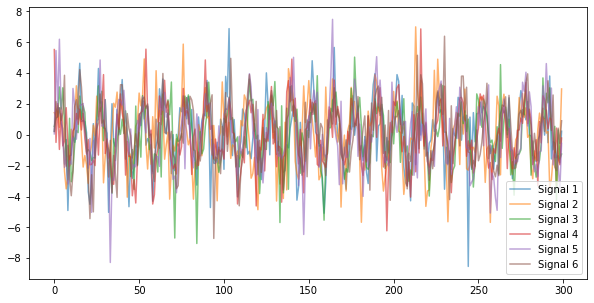

In [6]:
# Signal Parameters
n_signals = 6
amplitude = 2
noise = 1
freq = 0.08
phase_shift_range = [0, np.pi/2]
duration = 300
sampling_rate = 1

np.random.seed(1)
# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
spline_df=4

n_samples = int(np.rint(duration * sampling_rate))
x = np.arange(n_samples) * (1/sampling_rate)
phase_shift = np.random.uniform(phase_shift_range[0],phase_shift_range[1], n_signals)

signal_list = []
for i, p in enumerate(phase_shift):
    signal = amplitude * np.sin(2 * np.pi * freq * x + p)
    signal += np.random.laplace(0, noise, len(x))
    signal_series = pd.Series(signal, name=f'Signal_{i}')
    signal_list.append(signal_series)

fig, ax = plt.subplots(figsize=(10,5))
signal_labels = [f'Signal {i+1}' for i in range(n_signals)]
for i, signal in enumerate(signal_list):
    ax.plot(signal, label=signal_labels[i], alpha=0.6)
ax.legend()
    
signal_basis = []
signal_trim = []
for signal in signal_list:
    basis, lag_spline = lag_basis(signal, lag_vec, spline_df)
    # Trim NaNs introduced from lag splines
    na_indx = ~(np.isnan(basis).any(axis=1))
    signal_basis.append(basis[na_indx, :])
    signal_trim.append(signal[na_indx])

# Fit MCCA
mcca = MCCA(latent_dims=4, random_state=0)
mcca.fit(signal_basis)

# Print average pair-wise correlation
print(mcca.score(signal_basis))

# Correlation matrix
corr_mat = mcca.correlations(signal_basis)

# Get canonical components
cca_pred = mcca.transform(signal_basis)

# Get phase shift between first and second CCA comp
pred_signal1 = cca_pred[2][:,0]
pred_signal2 = cca_pred[2][:,1]

f, pxy = csd(pred_signal1, pred_signal2, 1, return_onesided=True)
f_indx = np.where( (f>(freq - 0.005)) & (f< (freq + 0.005)) ) 
print(np.angle(pxy)[f_indx])

### 8.5.2 Illustrate MCCA

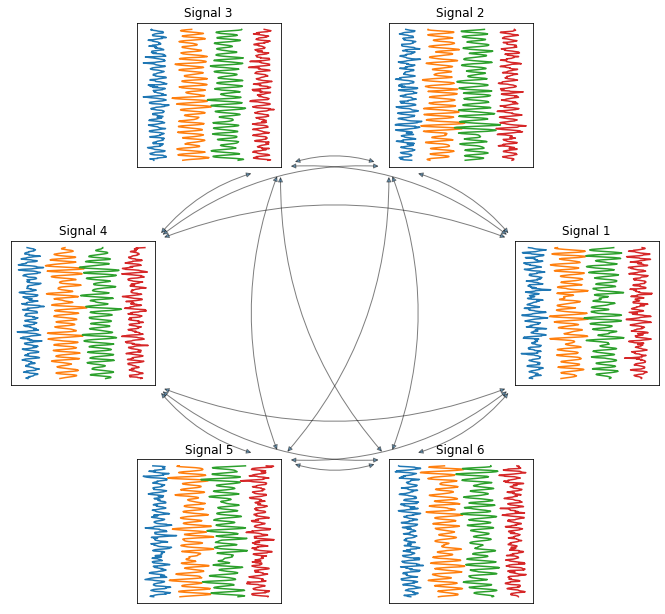

In [371]:
# Signal Parameters
N = 6
t = np.linspace(0,2*np.pi, N, endpoint=False)
r = 0.35
h = 0.9 - 2*r
w = h
X,Y = r*np.cos(t)-w/2.+ 0.5, r*np.sin(t)-h/2.+ 0.5

fig = plt.figure(figsize=(10,10))

signal_labels = [f'Signal {i+1}' for i in range(n_signals)]
axes = []
for i, (x,y) in enumerate(zip(X,Y)):
    ax = fig.add_axes([x, y, w, h])
    ax.plot(signal_basis[i][:,0]/10, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,1]/10 + 2, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,2]/10 + 4, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,3]/10 + 6, np.arange(signal_basis[i].shape[0])[::-1])
    ax.set_title(signal_labels[i], fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    axes.append(ax)

    
node_paths = {
    1: {
        2: [(0,1), (0,0), (10,30)],
        3: [(0,1), (1,0), (10,10)],
        4: [(0,1), (1,1), (10,10)],
        5: [()],
    },
    2: {
        3: [(0,0), (1,0), (15,15)],
        4: [(0,0), (1,1), (10,10)],
        6: [()]
    },
    3: {
        4: [(1,0), (1,1), (30,10)],
        5: [(1,0), (1,1), (10,10)],
        6: [(1,0), (0,1), (10,10)]
    },
    4: {
        1: [(1,0), (0,0), (10,10)],
        5: [(1,0), (1,1), (10,30)],
        6: [(1,0), (0,1), (10,10)]
    },
    5: {
        1: [(1,1), (0,0), (10,10)],
        2: [(1,1), (0,0), (10,10)],
        6: [(1,1), (0,1), (15,15)]
    },
    6: {
        1: [(0,1), (0,0), (30,10)],
        2: [(0,1), (0,0), (10,10)]
    }
}

edges = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4), (3,5), (3,6),
        (4,1), (4,5), (4,6), (5,1), (5,2), (5,6), (6,1), (6,2)]

for node_path in edges:
    i, j = node_path[0], node_path[1]
    con = ConnectionPatch(
        xyA=node_paths[i][j][0], coordsA=axes[i-1].transAxes,
        xyB=node_paths[i][j][1], coordsB=axes[j-1].transAxes, 
        shrinkA=node_paths[i][j][2][0], shrinkB=node_paths[i][j][2][1],
        connectionstyle='arc3, rad=.2', arrowstyle="<|-|>", alpha=0.5)
    axes[0].add_artist(con)



plt.show()

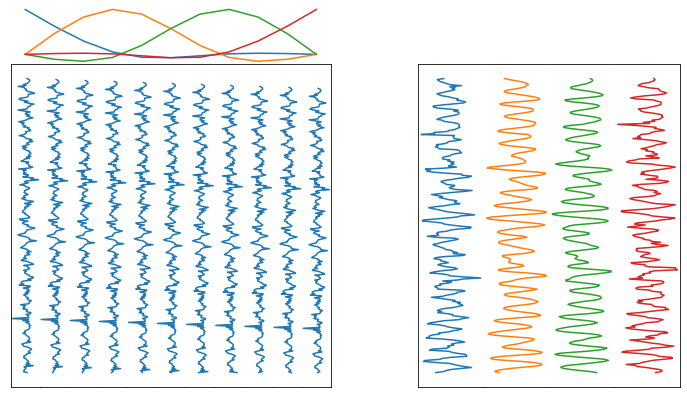

In [366]:
# Grab simulated signal
signal = signal_list[0]
signal_b = signal_basis[0]

# Start figure creation
fig = plt.figure(figsize=(12,7), constrained_layout=False)
gspec = fig.add_gridspec(1,2, wspace=0.3, width_ratios=[0.55, 0.45])

gsub1 = gspec[0].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])

gsub1_1 = gsub1[1,0].subgridspec(1,11, wspace=0)
# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
lag_nknots=4

for i, l in enumerate(lag_vec):
    if i > 0:
        ax = fig.add_subplot(gsub1_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub1_1[i])
    ax.plot(signal.shift(i), np.arange(len(signal)))
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (len(lag_vec)-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (len(lag_vec)-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

basis_lag = dmatrix("cr(x, df=4) - 1", {"x": lag_vec}, return_type='dataframe')
ax = fig.add_subplot(gsub1[0])
for i in range(basis_lag.shape[1]):
    ax.plot(basis_lag.iloc[:,i])
ax.axis('off')

gsub2 = gspec[1].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])

gsub2_1 = gsub2[1].subgridspec(1, signal_b.shape[1], wspace=0)
cmap = plt.get_cmap('tab10')
color_vec = [cmap(i) for i in range(signal_b.shape[1])]
for i in range(signal_b.shape[1]):
    if i > 0:
        ax = fig.add_subplot(gsub2_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub2_1[i])
    ax.plot(signal_b[:,i], np.arange(len(signal_b)), color=color_vec[i])
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (signal_b.shape[1]-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (signal_b.shape[1]-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

# 10. Misc